In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=8"
import jax
import jax.numpy as jnp
from flax import struct
from flax.core import frozen_dict

from tqdm.auto import tqdm
from functools import partial
import optax
#jax.config.update("jax_platform_name", "cpu")
jax.devices()
import matplotlib.pyplot as plt


In [3]:
import frozen_lake
import utils
import plotting
import policies

In [4]:
from typing import Any
from flax.training.train_state import TrainState
import flax


class DDQNTrainState(TrainState):
    params_targ: flax.core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    td_discount: float = struct.field(pytree_node=False, default=0.95)
    soft_update_rate: float = struct.field(pytree_node=False, default=0.001)

    @classmethod
    def create(cls, *, params, tx=optax.adam(1e-3), **kwargs):
        return super().create(params=params, params_targ=params, tx=tx, **kwargs)

    # @partial(jax.jit, static_argnums=(0,))
    # def temporal_difference(
    #     self,
    #     params: flax.core.FrozenDict[str, Any],
    #     params_targ: flax.core.FrozenDict[str, Any],
    #     transition: utils.Transition,
    # ):
    #     qstart = self.apply_fn(params, transition.obs)
    #     qselected = jnp.take(qstart, transition.action)
    #     qnext = self.apply_fn(params_targ, transition.next_obs)
    #     qnext = jax.lax.select(transition.done, 0.0, qnext.max())
    #     td = qselected - (transition.reward + self.td_discount * qnext)
    #     return td

    # @partial(jax.jit, static_argnums=(0,))
    # def td_gradient(self, transitions: utils.Transition):
    #     def td_loss_fn(params, params_targ, transition):
    #         rollout_td_fn = jax.vmap(self.temporal_difference, in_axes=(None, None, 0))
    #         td = rollout_td_fn(params, params_targ, transition)
    #         return optax.huber_loss(td).mean()

    #     return jax.grad(td_loss_fn)(self.params, self.params_targ, transitions)

    # @partial(jax.jit, static_argnums=(0,))
    # def update_nets(self, grads: jax.Array):
    #     def soft_update(params_targ, tau, params):
    #         return jax.tree_map(lambda pt, p: pt * (1 - tau) + p * tau, params_targ, params)

    #     new_params_targ = soft_update(self.params_targ, self.soft_update_rate, self.params)
    #     return self.apply_gradients(grads=grads, params_targ=new_params_targ)

    @partial(jax.jit, static_argnums=(0,))
    def temporal_difference(self, params, params_targ, transition):
        return 0.0

    @partial(jax.jit, static_argnums=(0,))
    def td_gradient(self, transitions: utils.Transition):
        return self.params

    @partial(jax.jit, static_argnums=(0,))
    def update_nets(self, grads: jax.Array):
        return self

In [5]:
rng_key = jax.random.PRNGKey(42)
map_size = 8

# declare env, policy and optimizer
env = frozen_lake.FrozenLake((map_size, map_size))
policy = policies.EpsilonGreedyPolicy(policies.ConvNet, dict(hidden=[16, 16, 16], out=4))

# initialize env
rng_key, rng_env_init, rng_reset = jax.random.split(rng_key, 3)
env_params = env.init(rng_env_init)
env_state, env_obs = env.reset(env_params, rng_reset)

# initialize qnet, target-qnet and optimizer
rng_key, rng_policy_init, rng_target_init = jax.random.split(rng_key, 3)
policy_params = policy.init(rng_policy_init, env_obs, method="get_qval")
target_policy_params = policy.init(rng_target_init, env_obs, method="get_qval")

train_state = DDQNTrainState.create(apply_fn=policy.apply, params=policy_params)

In [6]:
rollout = utils.get_rollout_fn(env, policy)


In [7]:
train_state.params["params"]["epsilon"] = 1.0

rng_key, rng_loop = jax.random.split(rng_key)
for rng_rollout in tqdm(jax.random.split(rng_loop, 1000)):
    transitions = rollout(env_params, train_state.params, rng_rollout, n_steps=100)
    
    for _ in range(10):
        grads = train_state.td_gradient(transitions)
        train_state = train_state.update_nets(grads)

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Non-hashable static arguments are not supported. An error occurred during a call to 'td_gradient' while trying to hash an object of type <class '__main__.DDQNTrainState'>, DDQNTrainState(step=0, apply_fn=<bound method Module.apply of EpsilonGreedyPolicy(
    # attributes
    net = ConvNet
    kwargs = {'hidden': [16, 16, 16], 'out': 4}
)>, params={'params': {'epsilon': 1.0, 'qnet': {'a': Array([[1.]], dtype=float32), 'Conv_0': {'kernel': Array([[[[-2.46516064e-01,  7.84640312e-02, -3.13787133e-01,
           2.04483852e-01,  1.91276163e-01,  3.21033537e-01,
          -2.35943036e-04,  2.58503914e-01, -5.95102906e-02,
          -4.03205752e-02, -1.07670940e-01, -1.02976197e-03,
          -9.31018665e-02, -1.62362307e-01, -6.55418560e-02,
           2.11395264e-01],
         [ 1.89905554e-01, -1.31849661e-01,  7.39977807e-02,
          -1.62028208e-01, -5.55871241e-02,  3.52997094e-01,
          -3.53372209e-02, -3.42133284e-01,  1.40904794e-02,
          -3.06679606e-02, -4.26021591e-02,  3.80425483e-01,
           3.37029725e-01,  1.98667273e-01, -1.58965871e-01,
           3.76648456e-01],
         [ 9.07869637e-02, -1.05414055e-01,  2.34664902e-01,
          -2.21294701e-01, -2.73144364e-01, -8.46566409e-02,
          -3.92669261e-01, -2.82002598e-01, -4.21243668e-01,
           1.39577478e-01,  2.80923415e-02,  8.65349025e-02,
          -1.27532184e-01, -1.92901254e-01, -2.83053517e-01,
          -1.06529735e-01]],

        [[ 1.33013964e-01, -1.71989813e-01,  1.03928439e-01,
          -4.71507832e-02,  1.12236269e-01, -2.54883707e-01,
          -3.41037586e-02,  2.60789961e-01, -5.47212288e-02,
          -1.09457806e-01,  1.99771672e-02, -1.23840570e-01,
          -1.49892554e-01,  3.51755172e-02, -1.11598752e-01,
          -3.04299504e-01],
         [ 2.33936131e-01, -6.56603351e-02, -5.81386052e-02,
          -4.41939607e-02, -2.51639307e-01,  4.98019382e-02,
           2.29927618e-02, -9.06406343e-02, -3.48926596e-02,
           1.56633958e-01, -3.23586583e-01,  1.73720479e-01,
          -3.14492464e-01,  2.54138820e-02,  1.00380126e-02,
          -5.53642847e-02],
         [ 4.85893376e-02,  2.97688376e-02, -8.06426182e-02,
          -1.79811984e-01,  1.55674025e-01, -9.06203091e-02,
          -1.34635583e-01, -5.80584593e-02,  2.13122204e-01,
          -7.31348321e-02,  1.81665301e-01, -1.92006126e-01,
          -3.61065209e-01,  2.81405151e-01, -6.02773316e-02,
           1.49737537e-01]],

        [[ 3.22265506e-01, -5.98292463e-02,  2.89549857e-01,
           7.05472529e-02, -1.39147058e-01,  2.93075085e-01,
           5.92305474e-02,  1.08402921e-02,  1.52291253e-01,
           4.20436785e-02, -3.96338403e-02, -1.18717268e-01,
           9.21167284e-02,  1.52317703e-01,  2.46311426e-01,
          -1.09231628e-01],
         [-2.39562124e-01,  1.69934034e-01, -7.77665451e-02,
           2.43520260e-01,  1.87390879e-01,  2.84372956e-01,
          -1.98322281e-01,  2.41317615e-01,  3.59811217e-01,
           2.09001780e-01,  1.83182523e-01, -3.54667246e-01,
           3.88283163e-01, -2.60360032e-01,  4.15476829e-01,
           1.03667388e-02],
         [ 1.98068589e-01,  1.51671216e-01, -4.11735982e-01,
           1.85956851e-01, -1.20783225e-01,  1.81351125e-01,
          -2.12837979e-01,  1.92519620e-01, -1.25709279e-02,
           3.07097107e-01, -8.42927173e-02,  7.40923509e-02,
          -1.77504301e-01, -2.97943413e-01,  3.14980835e-01,
          -1.86643124e-01]]],


       [[[-2.50949524e-02,  1.36784628e-01,  8.85204673e-02,
          -3.43298316e-01,  8.30522999e-02,  1.72194049e-01,
          -1.46723032e-01, -6.21056296e-02, -1.03704333e-01,
          -1.11063734e-01,  5.05507812e-02,  3.19801085e-02,
          -9.65138897e-02,  1.16110295e-02, -9.65391994e-02,
           5.47889620e-02],
         [-1.77961290e-01, -5.67809679e-02, -3.42772216e-01,
          -2.84877658e-01,  1.45117313e-01, -1.60330147e-01,
          -1.19076811e-01,  6.07956201e-02,  1.15848131e-01,
           1.20143555e-01, -1.18902393e-01, -1.06464334e-01,
          -2.55173504e-01,  3.17695230e-01,  5.94369769e-02,
          -2.00329572e-01],
         [ 2.82739729e-01, -1.92596659e-01, -1.75759643e-01,
           2.09258363e-01,  1.68264747e-01,  4.30273078e-02,
          -4.90778647e-02, -3.80612016e-01, -1.18448697e-01,
           1.14732541e-01,  2.07289010e-01,  5.73014468e-02,
          -1.79635599e-01,  2.58633584e-01,  1.65091693e-01,
          -1.99417491e-02]],

        [[ 9.08242632e-03, -2.23454580e-01, -1.53211847e-01,
           4.73133437e-02,  2.14477271e-01,  2.17704535e-01,
           3.09618831e-01,  1.79334283e-01, -1.59938395e-01,
           8.56618676e-03,  3.28017250e-02,  1.31712062e-02,
           1.25962779e-01,  1.87919676e-01, -4.62891124e-02,
           1.00908719e-01],
         [ 1.06355183e-01,  4.10384685e-02, -2.54010230e-01,
           1.30218074e-01,  1.57105580e-01,  2.19421238e-01,
          -2.27766067e-01,  4.30355733e-03, -1.07798435e-01,
           4.58837971e-02, -3.16001683e-01, -3.66595984e-01,
           1.08989187e-01, -6.11277707e-02,  2.71027297e-01,
           1.84420645e-01],
         [ 1.24390446e-01, -3.16800147e-01,  3.14798415e-01,
           9.07967612e-02, -1.64127816e-02, -1.23432674e-01,
           2.29686409e-01, -6.16287813e-02, -1.14250362e-01,
          -1.10045604e-01, -2.34810248e-01,  1.24679022e-01,
          -3.02075058e-01,  4.61775176e-02, -1.09535612e-01,
           9.96465236e-02]],

        [[ 3.67148146e-02, -1.19175483e-02,  2.22786099e-01,
           2.05160484e-01, -3.62332240e-02,  3.23035777e-01,
          -3.06860536e-01, -8.27570483e-02,  9.42131225e-03,
           2.09522277e-01,  8.43076408e-02, -3.87320399e-01,
          -4.39729318e-02,  1.45397857e-01, -1.11560173e-01,
          -7.59451389e-02],
         [ 6.32048696e-02, -2.49224097e-01,  2.20216699e-02,
           3.90170179e-02, -2.41349056e-01,  3.85824680e-01,
           1.76601216e-01,  1.89749181e-01, -2.17024479e-02,
          -3.16027194e-01, -3.77351403e-01,  8.72508436e-02,
           1.96573455e-02,  2.94965096e-02,  3.11609626e-01,
           3.26001942e-01],
         [-2.02770725e-01,  1.69588238e-01,  2.00134918e-01,
          -3.75874668e-01,  1.20463334e-01, -2.84957647e-01,
           2.34351099e-01, -1.75520539e-01,  3.47383887e-01,
           1.81932703e-01, -1.71748269e-02,  1.11065842e-01,
          -2.18939528e-01,  1.04415990e-01,  5.36594167e-02,
           1.19280651e-01]]],


       [[[ 6.36548400e-02, -1.31897494e-01, -1.35904580e-01,
          -1.96002871e-01,  1.50438040e-01, -2.20491722e-01,
          -4.90342192e-02,  4.71533388e-02, -9.91793200e-02,
           1.13021217e-01,  7.65780658e-02, -3.42907518e-01,
          -4.12121601e-02,  7.65234753e-02,  1.26109868e-01,
          -2.43830130e-01],
         [-1.26724124e-01,  1.06029846e-01,  2.66651005e-01,
          -2.76803732e-01, -1.43923968e-01, -9.32339206e-02,
           7.74757937e-02, -2.14159071e-01, -2.44786873e-01,
           3.38940620e-01, -2.37338822e-02, -1.33515045e-01,
          -7.40636662e-02, -6.70893341e-02, -8.78394693e-02,
          -1.30992860e-01],
         [ 1.81056038e-01,  2.45650873e-01,  1.17950670e-01,
           3.07475477e-01, -3.75838071e-01,  8.56175050e-02,
           9.54522491e-02,  1.08161062e-01,  1.37680367e-01,
           2.88966209e-01,  1.54036000e-01, -4.71482202e-02,
          -1.64793983e-01, -8.67872220e-03,  2.28789032e-01,
           1.09732524e-02]],

        [[-4.02142704e-02,  3.60013843e-01, -2.57613480e-01,
          -4.58626077e-02, -3.76309931e-01, -2.66599059e-02,
          -3.91932353e-02,  7.38474801e-02,  1.97824627e-01,
           3.76434863e-01,  6.70603663e-02, -3.99298579e-01,
          -1.33435890e-01,  3.01837951e-01, -1.39952689e-01,
          -1.45816043e-01],
         [-2.55163640e-01,  7.03799073e-03, -9.61569846e-02,
          -2.03707099e-01, -2.30721474e-01,  1.03102997e-01,
          -2.62519926e-01, -2.98488792e-02,  1.84028924e-01,
           3.25787783e-01, -7.45305195e-02, -2.37730175e-01,
           3.31154227e-01,  1.72881439e-01, -4.13440496e-01,
          -2.39978045e-01],
         [ 6.76835924e-02, -1.62690014e-01, -2.84875929e-01,
          -2.49495894e-01, -1.48589686e-01, -2.01329440e-02,
           2.91004539e-01, -3.09348017e-01, -6.11874089e-02,
          -8.44847709e-02,  4.17289019e-01,  2.00658634e-01,
          -1.44260526e-01,  6.52218014e-02, -6.52628988e-02,
          -1.73016433e-02]],

        [[-7.82972798e-02,  8.26796219e-02,  6.18610159e-02,
           2.07942694e-01,  6.45450056e-02,  2.45791391e-01,
           3.00794393e-01,  7.38404915e-02,  7.92030022e-02,
          -5.20117618e-02,  1.13196366e-01,  2.08417654e-01,
           8.84435419e-03, -1.75333455e-01, -1.98798582e-01,
          -5.99660091e-02],
         [ 7.86503851e-02, -2.08906438e-02, -1.04311528e-03,
           2.97714561e-01,  3.10421765e-01,  1.10228620e-01,
           5.25145084e-02, -1.13499105e-01, -3.12677532e-01,
          -2.13522494e-01, -7.88313970e-02, -3.57070029e-01,
           7.83157721e-03,  1.32198021e-01,  2.48455584e-01,
          -1.74872726e-01],
         [-2.46877998e-01,  1.36146694e-01, -1.75547421e-01,
          -1.49441436e-02,  3.71045172e-01,  4.08287160e-03,
           1.36605203e-01,  1.64347813e-01,  1.02843810e-03,
          -4.30460632e-01,  2.09175944e-01,  9.13716778e-02,
          -1.02820788e-02, -6.67039976e-02, -2.27816269e-01,
          -3.16078871e-01]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_1': {'kernel': Array([[[[ 1.26764312e-01, -3.07592135e-02, -2.43666600e-02, ...,
           1.47536725e-01,  2.42375642e-01,  5.72364368e-02],
         [ 4.39094193e-03,  5.65710962e-02, -1.56641424e-01, ...,
           2.47838423e-02,  4.28212024e-02,  7.90962875e-02],
         [-6.38824180e-02,  5.93176074e-02, -4.59512137e-03, ...,
           8.82463679e-02,  1.04777806e-04,  2.17764184e-01],
         ...,
         [-1.78085715e-01, -1.81979984e-01,  6.75054491e-02, ...,
          -3.80520076e-02, -1.58974037e-01,  1.13631248e-01],
         [-5.70946597e-02,  1.14357084e-01, -7.16704875e-02, ...,
           7.79385446e-03,  1.60587579e-01, -1.53442755e-01],
         [ 3.15593742e-02,  9.65666026e-02, -1.72441408e-01, ...,
           9.89136286e-03, -5.56013081e-03,  8.25756565e-02]],

        [[-1.68339297e-01, -1.02331132e-01,  6.16884418e-02, ...,
          -1.39659286e-01,  2.25999326e-01,  2.42036264e-02],
         [-1.25003159e-01,  4.71460745e-02,  1.52863413e-01, ...,
           9.62717179e-03, -1.46578690e-02, -1.79457530e-01],
         [ 5.94066307e-02, -7.81889260e-02, -6.64325431e-02, ...,
           1.16501972e-01, -2.59615213e-01, -5.50943166e-02],
         ...,
         [ 1.66532304e-02,  1.05090253e-01, -1.75852880e-01, ...,
           4.38796505e-02, -1.50005654e-01,  1.34157777e-01],
         [-2.07029745e-01, -7.37659782e-02,  1.04746588e-01, ...,
           8.08293447e-02, -1.51106026e-02,  5.05464263e-02],
         [ 9.50511694e-02, -5.72752915e-02,  2.56849378e-01, ...,
           3.38369161e-02,  8.17783400e-02,  1.84244931e-01]]],


       [[[-7.06388354e-02, -1.27979547e-01, -3.48610664e-03, ...,
           1.00024417e-02,  6.79321662e-02, -5.94238378e-02],
         [ 1.71946302e-01,  1.78414304e-02,  7.73138274e-03, ...,
          -1.37619302e-01, -3.25213261e-02, -3.43066417e-02],
         [ 1.22066028e-01, -6.00059109e-04,  2.27286685e-02, ...,
           6.62710518e-02,  2.00606242e-01,  1.20032601e-01],
         ...,
         [-1.19290330e-01, -2.55985588e-01,  3.56511921e-02, ...,
           8.35742876e-02,  1.22811105e-02,  2.31139153e-01],
         [ 4.24269997e-02, -1.85703449e-02,  1.76359609e-01, ...,
          -1.33109123e-01,  1.67416379e-01, -9.58966650e-03],
         [ 8.93493742e-02, -4.68352390e-03, -3.59907933e-02, ...,
          -1.00670848e-02, -1.75866321e-01,  3.30281667e-02]],

        [[ 8.39051306e-02,  9.80109200e-02, -1.43256545e-01, ...,
           1.68555811e-01,  3.91162559e-02,  4.35148813e-02],
         [-1.75823420e-01, -1.42957732e-01,  6.63133804e-03, ...,
          -4.88767847e-02,  6.51035979e-02,  4.01241370e-02],
         [ 7.44458511e-02, -2.29638472e-01, -2.97429450e-02, ...,
           2.38526210e-01, -1.33839786e-01, -8.13915394e-03],
         ...,
         [-1.89828947e-01,  1.58649519e-01,  1.01991683e-01, ...,
          -1.41158894e-01,  8.87191892e-02, -1.68910414e-01],
         [ 9.36551020e-02,  1.27347440e-01,  2.03112543e-01, ...,
           1.90437213e-01, -1.16524197e-01,  3.44750434e-02],
         [ 2.03089893e-01,  5.01732901e-02, -9.25286487e-02, ...,
           1.44989669e-01,  9.92030725e-02,  1.76365063e-01]]]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_0': {'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_2': {'kernel': Array([[[[-1.78562310e-02, -6.44430444e-02, -2.92621329e-02, ...,
           8.96236598e-02,  5.59779070e-02, -2.25809589e-02],
         [ 1.22829201e-02,  1.57150552e-02, -1.15058636e-02, ...,
          -1.07832819e-01,  4.64955233e-02, -4.36528511e-02],
         [-1.10131837e-02,  1.47363720e-02,  6.91666156e-02, ...,
           1.10995911e-01, -3.56397144e-02,  9.62742865e-02],
         ...,
         [ 1.12124709e-02, -2.99970489e-02,  5.88570088e-02, ...,
           1.16323203e-01, -1.06746070e-01,  3.72492778e-03],
         [-1.48915192e-02, -6.23896644e-02, -2.13820916e-02, ...,
           7.64533728e-02, -6.81680918e-04,  3.78869334e-03],
         [-1.33808484e-04, -8.63727629e-02,  9.94986072e-02, ...,
           1.01388104e-01, -7.48836696e-02,  1.66511871e-02]],

        [[-4.74064276e-02, -2.75815688e-02, -4.65421677e-02, ...,
          -4.87535857e-02, -4.95321639e-02, -4.16276194e-02],
         [-6.69186115e-02,  4.17548604e-03, -5.08007631e-02, ...,
          -1.01499453e-01,  4.62687202e-02, -4.70040143e-02],
         [ 1.22328378e-01,  2.89516803e-02, -7.86179081e-02, ...,
          -3.02998833e-02,  6.20176494e-02, -5.04463613e-02],
         ...,
         [ 3.99553999e-02,  6.15095571e-02, -4.41672653e-02, ...,
           2.94584837e-02,  7.72012770e-02, -7.47459233e-02],
         [ 2.90248767e-02,  1.92555953e-02, -3.01805809e-02, ...,
          -1.15545735e-01, -5.07840440e-02, -6.36788756e-02],
         [-1.18531948e-02, -7.16894194e-02,  7.38887407e-04, ...,
           3.06877010e-02,  9.61727202e-02, -5.32202385e-02]],

        [[-1.70260653e-01, -6.35430962e-02, -5.34818843e-02, ...,
          -1.55303366e-02,  3.03203966e-02, -6.21738061e-02],
         [-5.59810884e-02, -1.18082382e-01,  4.07888107e-02, ...,
           1.57517299e-01, -5.37700169e-02, -1.45404533e-01],
         [ 5.90595640e-02, -2.63234787e-02, -4.22603935e-02, ...,
          -4.49234582e-02,  7.36269280e-02, -3.09139509e-02],
         ...,
         [ 1.86884329e-02, -2.60528903e-02,  4.89080623e-02, ...,
           5.06986454e-02, -3.04964632e-02, -2.04712320e-02],
         [-1.32801577e-01,  7.38699362e-03, -9.98813510e-02, ...,
           3.08994465e-02, -1.08598508e-02,  1.30717121e-02],
         [-4.71436605e-02,  1.84844524e-01,  8.30320194e-02, ...,
          -2.19519436e-02,  1.12633035e-01,  3.23160142e-02]]],


       [[[ 1.12033948e-01, -8.46211389e-02, -1.80529524e-02, ...,
          -3.10631432e-02, -1.39349952e-01, -8.20132867e-02],
         [-1.05296947e-01,  3.56875919e-02, -1.25276089e-01, ...,
          -3.74574214e-02,  7.79042989e-02,  1.13730893e-01],
         [ 3.56972292e-02,  5.80844395e-02,  7.11256564e-02, ...,
           9.64478031e-02, -5.98242804e-02, -8.39578509e-02],
         ...,
         [-6.94433823e-02,  1.53333247e-01, -6.45612255e-02, ...,
           1.23594599e-02,  1.07615940e-01, -1.71487436e-01],
         [-1.21024195e-02, -5.00800041e-03,  1.17108589e-02, ...,
           3.89519110e-02,  4.93994541e-02,  4.92594168e-02],
         [-7.39318952e-02, -8.51959065e-02,  1.32851884e-01, ...,
          -1.17948279e-01,  4.19153497e-02,  4.58449200e-02]],

        [[-5.59865572e-02,  2.13501621e-02,  4.02844772e-02, ...,
           1.09307058e-01, -2.90102083e-02, -4.41040732e-02],
         [ 1.18254244e-01, -2.45156530e-02,  5.50438501e-02, ...,
          -1.55338151e-02, -9.71496031e-02,  1.23519704e-01],
         [ 1.17608504e-02,  7.34331012e-02,  1.02338374e-01, ...,
          -2.69007459e-02,  1.24387793e-01,  7.61067942e-02],
         ...,
         [-2.93480251e-02,  1.52306426e-02, -1.51405320e-01, ...,
          -6.28110468e-02, -1.51329204e-01, -1.28189608e-01],
         [-3.61270122e-02, -4.48745750e-02, -7.21659511e-02, ...,
           5.51231541e-02,  1.36442840e-01,  8.23431835e-02],
         [-1.03672639e-01, -3.38596404e-02,  9.38165560e-02, ...,
          -1.23648077e-01, -5.06454892e-02, -4.54549119e-03]],

        [[ 1.26410067e-01,  1.26028404e-01, -6.09330833e-02, ...,
           1.33822272e-02,  8.98732543e-02,  4.19696793e-02],
         [ 1.15498066e-01,  1.34524569e-01, -1.36612207e-01, ...,
           1.54547349e-01, -4.94586043e-02,  1.29996732e-01],
         [-1.47356624e-02, -8.44042897e-02, -2.58258302e-02, ...,
          -9.82020274e-02, -7.50914440e-02,  9.94924456e-02],
         ...,
         [-5.80944866e-02, -9.62903649e-02, -1.09559773e-02, ...,
          -2.32346766e-02, -8.44162554e-02,  1.19311519e-01],
         [-6.26310557e-02,  1.06162373e-02,  4.60376665e-02, ...,
          -3.31127644e-02, -1.56166583e-01, -2.35610586e-02],
         [-5.44116311e-02,  1.24828279e-01,  7.26500228e-02, ...,
           8.35231040e-03,  2.66685076e-02,  2.96103004e-02]]],


       [[[ 1.26212567e-01,  9.62529629e-02,  6.77720159e-02, ...,
           1.00211045e-02, -7.56128952e-02,  1.64657041e-01],
         [ 1.04090549e-01,  7.93544017e-03, -1.93819555e-03, ...,
          -1.15901493e-01, -1.30462339e-02,  7.54537210e-02],
         [-9.35401767e-03, -7.76422396e-02,  2.28168871e-02, ...,
          -1.17902635e-02,  2.26215547e-04,  8.62382054e-02],
         ...,
         [ 5.47199473e-02, -6.66677207e-02,  6.14424888e-03, ...,
           2.34298725e-02,  5.22175580e-02,  2.80521773e-02],
         [-1.77447289e-01, -1.00509994e-01,  1.00905389e-01, ...,
           3.03895622e-02,  9.63777229e-02, -6.25200495e-02],
         [-5.44782802e-02,  7.83530772e-02, -8.26437324e-02, ...,
           1.24149591e-01, -1.59754828e-02, -8.36709142e-02]],

        [[ 1.40150905e-01,  8.79036933e-02,  1.30852968e-01, ...,
           1.40966833e-01, -8.55951086e-02,  6.86689187e-03],
         [ 5.23651987e-02, -7.16548562e-02, -2.56980583e-02, ...,
          -2.17289552e-02, -1.06840976e-01, -7.95226246e-02],
         [-1.49295190e-02,  3.99096869e-02, -5.82914799e-02, ...,
           6.09921142e-02,  1.62023351e-01, -4.94796038e-02],
         ...,
         [ 9.15931910e-02,  1.00265518e-01,  6.25060545e-03, ...,
          -3.94767486e-02,  7.95673300e-03,  3.05058453e-02],
         [-9.92005039e-03, -1.05994642e-02,  1.28673427e-02, ...,
          -4.84893285e-02, -4.37598638e-02,  5.80872744e-02],
         [-2.51305047e-02, -1.08639136e-01, -4.94761355e-02, ...,
           7.43539780e-02, -5.02983704e-02,  7.66639635e-02]],

        [[-9.94455069e-02,  7.84977004e-02, -3.83438095e-02, ...,
           1.36684239e-01, -4.77236249e-02, -4.39739078e-02],
         [-2.81625595e-02,  1.06122755e-02, -1.29549960e-02, ...,
           1.14969857e-01,  1.46752208e-01, -3.70907597e-02],
         [ 1.06789313e-01, -5.69019802e-02,  1.65254369e-01, ...,
           2.76052188e-02,  6.81011900e-02, -7.96099380e-02],
         ...,
         [ 8.29422325e-02, -5.64138182e-02, -1.46424383e-01, ...,
          -1.10776149e-01,  1.38293542e-02, -3.74998786e-02],
         [-1.00189470e-01,  1.05013236e-01,  1.23694964e-01, ...,
           5.24551980e-02, -1.46421604e-02,  8.16517919e-02],
         [-1.55257151e-01,  3.57251577e-02, -4.74663600e-02, ...,
          -1.56014770e-01,  9.56100300e-02, -1.49625525e-01]]]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_3': {'kernel': Array([[[[ 0.00911125,  0.08132156, -0.0844309 , ..., -0.05993934,
           0.28290758, -0.04893084],
         [ 0.08505765,  0.04514361, -0.28040984, ..., -0.08785684,
           0.0922165 ,  0.03241619],
         [ 0.2101899 ,  0.00908189,  0.15008989, ..., -0.03098753,
          -0.06110891, -0.04073446],
         ...,
         [-0.04138706,  0.20531677, -0.1393816 , ..., -0.00644405,
          -0.01228322,  0.28117448],
         [ 0.03317038, -0.15544912, -0.10544807, ...,  0.11325958,
           0.13387543,  0.02704174],
         [-0.01271036, -0.20752448, -0.01097528, ..., -0.14139356,
           0.00495661, -0.02512432]],

        [[-0.09677426,  0.05922079, -0.01145695, ...,  0.13364469,
          -0.10559176, -0.17271991],
         [-0.06435864, -0.06246624, -0.04355017, ...,  0.16083303,
           0.03202494,  0.09367257],
         [-0.06364128,  0.05420515, -0.1595871 , ..., -0.28351444,
           0.06211719, -0.21974675],
         ...,
         [-0.15895632, -0.06968889, -0.14431445, ...,  0.1955648 ,
           0.12605932, -0.27344167],
         [ 0.04962128, -0.13156651,  0.07082111, ..., -0.0355838 ,
           0.06127549,  0.0730328 ],
         [-0.00538803,  0.1356463 , -0.0969862 , ..., -0.05241053,
           0.09221849, -0.0799234 ]]],


       [[[-0.10984463,  0.05763986,  0.18305358, ..., -0.13139847,
           0.06052766,  0.17400084],
         [ 0.01467534, -0.02751145,  0.03979489, ..., -0.03601758,
           0.05399316,  0.07658666],
         [ 0.04948487,  0.03688845, -0.19013132, ..., -0.11573262,
          -0.10712691,  0.05444184],
         ...,
         [ 0.06459319, -0.1958623 ,  0.13659833, ..., -0.13745233,
          -0.06818794,  0.19719708],
         [ 0.19153886, -0.11404169,  0.11156621, ..., -0.01558514,
           0.16374673,  0.20682089],
         [ 0.04701542,  0.11688354,  0.09430366, ...,  0.07785323,
          -0.1006914 , -0.1855602 ]],

        [[ 0.09358817,  0.01139657, -0.03416369, ...,  0.0420729 ,
          -0.15677623, -0.06866497],
         [-0.08918866, -0.2604313 ,  0.02910357, ..., -0.10168242,
          -0.2810239 , -0.00612618],
         [ 0.00986378, -0.0234008 ,  0.16750556, ..., -0.07848515,
           0.08399639,  0.00791251],
         ...,
         [ 0.10710481, -0.07676857, -0.14810923, ..., -0.16913934,
           0.03587588,  0.1792271 ],
         [-0.16432038, -0.00470367, -0.11272664, ...,  0.00485389,
          -0.09837613, -0.02795264],
         [-0.10152123, -0.13271156, -0.17105995, ..., -0.10996713,
           0.03158821,  0.05819573]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_1': {'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_4': {'kernel': Array([[[[ 0.04207619,  0.03990488,  0.16965312, ..., -0.05165224,
           0.0897336 , -0.0674474 ],
         [ 0.05728912, -0.0639746 , -0.05033747, ..., -0.08572891,
           0.09079811,  0.01999984],
         [ 0.14762414,  0.04510744,  0.03667118, ..., -0.10990208,
           0.01089521,  0.06904753],
         ...,
         [-0.03154688,  0.08937824,  0.05474353, ...,  0.03888261,
           0.08861231, -0.12683687],
         [ 0.13143896, -0.0489403 , -0.02599607, ..., -0.10874669,
          -0.09769353,  0.16934809],
         [ 0.00679077, -0.10026499, -0.02177099, ...,  0.10342272,
          -0.11400662, -0.02081761]],

        [[-0.01535638,  0.08657975,  0.1479972 , ...,  0.00328073,
           0.02667823, -0.08850171],
         [-0.06168921, -0.09362657,  0.04280635, ...,  0.01763431,
          -0.06949451, -0.00481522],
         [-0.0452132 , -0.02530869,  0.16060959, ...,  0.04259119,
           0.03853378, -0.07561364],
         ...,
         [-0.13667887,  0.01990172,  0.03325699, ...,  0.10264482,
           0.01056183,  0.05715251],
         [-0.02661737,  0.11050887,  0.01184086, ..., -0.03457759,
           0.13206214, -0.12291715],
         [-0.01532645,  0.05812466,  0.11569396, ..., -0.05322506,
           0.01725096, -0.01426843]],

        [[ 0.02098103, -0.07677063, -0.03999395, ..., -0.11102212,
          -0.13941   , -0.07745098],
         [-0.00602035, -0.0165326 ,  0.14780845, ..., -0.06572869,
          -0.019143  , -0.09958608],
         [-0.0961203 ,  0.07889894,  0.07422554, ..., -0.02644775,
          -0.05839205, -0.02308629],
         ...,
         [ 0.14470573,  0.09864418,  0.00380381, ...,  0.08336689,
           0.05488127, -0.11337083],
         [-0.05805243,  0.01826314, -0.14698902, ..., -0.08108795,
          -0.04152015, -0.01748024],
         [ 0.05320724,  0.10228917,  0.0639428 , ...,  0.05772094,
           0.04811365, -0.09071003]]],


       [[[ 0.08368134, -0.06959084, -0.04866542, ...,  0.01450967,
          -0.11059259,  0.00992767],
         [-0.00156451,  0.02152686, -0.17996253, ...,  0.13547397,
           0.01275917,  0.01837767],
         [-0.04341924, -0.10766221,  0.09853814, ..., -0.03076742,
          -0.1284714 , -0.0195714 ],
         ...,
         [-0.10562381,  0.01222771, -0.1200614 , ...,  0.01578495,
          -0.03621426, -0.14408901],
         [ 0.11023469,  0.12201194,  0.03292211, ..., -0.04126388,
          -0.17897813, -0.02572452],
         [ 0.01569413, -0.07824022,  0.11780656, ...,  0.06061694,
          -0.03535371,  0.03600311]],

        [[-0.04135849, -0.05055568,  0.11175611, ..., -0.01655504,
           0.02077597,  0.02845976],
         [ 0.0087061 , -0.0536474 ,  0.10469904, ...,  0.11525919,
           0.07855048,  0.0473695 ],
         [-0.04204375, -0.07833011,  0.03491861, ..., -0.05404294,
          -0.15822406, -0.15998033],
         ...,
         [ 0.01658921,  0.08986031,  0.03775188, ..., -0.05599389,
          -0.18320625,  0.09115727],
         [-0.02748734, -0.0855611 ,  0.02803996, ...,  0.08706919,
          -0.10775607, -0.00384434],
         [ 0.09903114, -0.09157021, -0.15907398, ..., -0.04525882,
          -0.02418255,  0.01807766]],

        [[ 0.08727682,  0.0622506 , -0.03184195, ...,  0.04859319,
          -0.01685902, -0.06263751],
         [ 0.03502535, -0.08474132, -0.14963627, ...,  0.03611751,
          -0.01169859,  0.10442862],
         [-0.07561483,  0.12922348,  0.05384291, ..., -0.04826525,
          -0.09367938, -0.1317753 ],
         ...,
         [-0.00567301, -0.02167015, -0.06189806, ..., -0.09997882,
           0.06306244,  0.14477685],
         [ 0.04895188, -0.07039163,  0.03942332, ..., -0.12877846,
           0.04219787, -0.02796654],
         [ 0.08615573, -0.05516168,  0.00925459, ..., -0.03363764,
           0.02274624,  0.02509129]]],


       [[[ 0.03028186, -0.00454384, -0.02571398, ..., -0.02803403,
          -0.11897173,  0.00103616],
         [-0.06148073,  0.05572775,  0.08177418, ..., -0.05686824,
          -0.0063542 , -0.05004189],
         [ 0.10938914, -0.16042477, -0.05591199, ..., -0.07584763,
           0.13472986, -0.0302388 ],
         ...,
         [-0.07261384,  0.00950236,  0.05586309, ..., -0.09745346,
          -0.0739504 , -0.15658075],
         [-0.06577565, -0.08418684,  0.04264158, ...,  0.15878144,
          -0.0650818 ,  0.02847456],
         [-0.03418723,  0.06486289, -0.106012  , ..., -0.02027448,
          -0.03642716,  0.14310549]],

        [[ 0.13528885, -0.05732926,  0.09728971, ..., -0.10691341,
          -0.04476354, -0.11311396],
         [-0.00499212, -0.0708012 ,  0.17734486, ..., -0.00687554,
           0.05249491,  0.13870485],
         [-0.03317818, -0.04736037,  0.11735559, ..., -0.02146999,
           0.01101725, -0.0261605 ],
         ...,
         [-0.03489276, -0.12451522, -0.01602381, ..., -0.10347307,
          -0.02273506, -0.08183142],
         [ 0.04256998,  0.03065054, -0.04306943, ..., -0.0390404 ,
          -0.0888254 , -0.04578056],
         [-0.06412666, -0.05774824, -0.09351369, ..., -0.08222891,
          -0.1030325 , -0.02705351]],

        [[-0.072937  ,  0.07502395,  0.02510524, ...,  0.09332182,
          -0.00087703,  0.14755471],
         [ 0.0873142 ,  0.01332492,  0.13810968, ...,  0.04454986,
          -0.08104305,  0.02550093],
         [-0.16461642,  0.0372925 ,  0.01714668, ..., -0.06980179,
          -0.0025652 , -0.03360529],
         ...,
         [ 0.08350112,  0.11223499,  0.04475147, ...,  0.04125362,
           0.03196475, -0.02255564],
         [ 0.16453129, -0.08857702, -0.12195189, ..., -0.02666775,
          -0.02240545,  0.03512345],
         [-0.02668501, -0.01103759, -0.00412131, ..., -0.07342134,
           0.04761905, -0.09477066]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_5': {'kernel': Array([[[[ 0.09462014, -0.04975813,  0.07845177, ..., -0.11028674,
          -0.18336323,  0.05200576],
         [-0.19860756,  0.12686911, -0.14862335, ...,  0.0020944 ,
           0.01536913, -0.05255339],
         [ 0.15645194,  0.11776999, -0.10391416, ...,  0.10023107,
          -0.08122724,  0.1731915 ],
         ...,
         [-0.14144422, -0.06603128, -0.09165837, ...,  0.10221061,
           0.01568137, -0.25426605],
         [ 0.16140725, -0.0215593 , -0.14665364, ..., -0.28183997,
          -0.00326336, -0.10861149],
         [-0.05451011,  0.04710284,  0.19487423, ..., -0.04892134,
          -0.16134258, -0.08255936]],

        [[-0.07442021,  0.2465919 ,  0.21977982, ...,  0.12991104,
          -0.14219841,  0.14404829],
         [-0.09606492, -0.01197752, -0.07383267, ...,  0.0026086 ,
          -0.04335082,  0.01033272],
         [ 0.12084179, -0.06795669, -0.04695918, ...,  0.18547876,
           0.23857653,  0.14584514],
         ...,
         [ 0.24936546,  0.09265764, -0.19101582, ..., -0.03852451,
           0.00814188, -0.12732631],
         [-0.11284205, -0.14939816, -0.07120851, ..., -0.1311111 ,
           0.0026759 , -0.20184702],
         [ 0.07214081, -0.12496056,  0.1138773 , ..., -0.01880813,
          -0.13203612, -0.12903199]]],


       [[[ 0.16501966,  0.11986373, -0.01527953, ..., -0.12326884,
          -0.16092514,  0.09996216],
         [-0.1548424 ,  0.11493877, -0.05449776, ...,  0.10940284,
          -0.02860323,  0.01364183],
         [ 0.07511818,  0.15514064, -0.16572164, ..., -0.18264207,
           0.03180689, -0.05586714],
         ...,
         [-0.05134157,  0.10434814, -0.09763908, ...,  0.11695514,
           0.17912452,  0.1429287 ],
         [-0.15874927, -0.02168137, -0.07568359, ..., -0.11097164,
           0.01415065,  0.00640689],
         [ 0.11355082, -0.00695466,  0.1527608 , ...,  0.11578346,
          -0.14119521,  0.03813284]],

        [[-0.11571133,  0.17508216,  0.0332634 , ...,  0.14212121,
           0.00091349, -0.0630032 ],
         [ 0.06937294,  0.12896216,  0.02679265, ...,  0.14689387,
          -0.10863993,  0.13079081],
         [-0.18322933, -0.04350295,  0.23815002, ...,  0.01352925,
          -0.10860274,  0.06123595],
         ...,
         [-0.06707408, -0.19958253,  0.08136105, ..., -0.09479347,
          -0.15171264, -0.26293138],
         [-0.04560201, -0.03302134,  0.23979034, ...,  0.20781183,
          -0.01987334, -0.11203845],
         [ 0.12681147,  0.17175913,  0.08459513, ...,  0.02352471,
           0.03019902,  0.17679712]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_2': {'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Dense_0': {'kernel': Array([[-0.09358857, -0.1898444 , -0.1645634 , -0.1792992 ],
       [ 0.2701032 ,  0.03755564, -0.16016316,  0.13478734],
       [ 0.10597266, -0.05184377,  0.2903779 ,  0.50296664],
       [-0.17692302, -0.2447166 , -0.12542123,  0.43986982],
       [ 0.08162747,  0.13989782, -0.30540088, -0.11908829],
       [-0.30967525,  0.10076848, -0.08307593,  0.03928227],
       [ 0.08658183,  0.19085062,  0.2649379 ,  0.49657798],
       [ 0.38811648,  0.12299798, -0.20075467,  0.42540163],
       [-0.10374843, -0.03880738, -0.43020973, -0.04130455],
       [-0.05305182,  0.1651307 , -0.0766804 , -0.06600654],
       [-0.10555296,  0.2432348 , -0.19176881,  0.04346335],
       [ 0.14965288, -0.23662229, -0.01413844,  0.18764067],
       [-0.02009688,  0.02448533, -0.02104616, -0.17368716],
       [-0.17221718, -0.06259624,  0.10984249,  0.21362887],
       [-0.27375543, -0.16192447, -0.3097228 , -0.22234511],
       [ 0.19237234,  0.2192318 ,  0.29212025, -0.21155718]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f67a40b0280>, update=<function chain.<locals>.update_fn at 0x7f67a40b0430>), opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu={'params': {'epsilon': Array(0., dtype=float32), 'qnet': {'Conv_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]]], dtype=float32)}, 'Conv_1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_2': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_3': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_4': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_5': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Dense_0': {'bias': Array([0., 0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)}, 'LayerNorm_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'scale': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'scale': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_2': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'scale': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'a': Array([[0.]], dtype=float32)}}}, nu={'params': {'epsilon': Array(0., dtype=float32), 'qnet': {'Conv_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]]], dtype=float32)}, 'Conv_1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_2': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_3': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_4': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Conv_5': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'Dense_0': {'bias': Array([0., 0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)}, 'LayerNorm_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'scale': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'scale': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_2': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'scale': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'a': Array([[0.]], dtype=float32)}}}), EmptyState()), params_targ={'params': {'epsilon': 1.0, 'qnet': {'a': Array([[1.]], dtype=float32), 'Conv_0': {'kernel': Array([[[[-2.46516064e-01,  7.84640312e-02, -3.13787133e-01,
           2.04483852e-01,  1.91276163e-01,  3.21033537e-01,
          -2.35943036e-04,  2.58503914e-01, -5.95102906e-02,
          -4.03205752e-02, -1.07670940e-01, -1.02976197e-03,
          -9.31018665e-02, -1.62362307e-01, -6.55418560e-02,
           2.11395264e-01],
         [ 1.89905554e-01, -1.31849661e-01,  7.39977807e-02,
          -1.62028208e-01, -5.55871241e-02,  3.52997094e-01,
          -3.53372209e-02, -3.42133284e-01,  1.40904794e-02,
          -3.06679606e-02, -4.26021591e-02,  3.80425483e-01,
           3.37029725e-01,  1.98667273e-01, -1.58965871e-01,
           3.76648456e-01],
         [ 9.07869637e-02, -1.05414055e-01,  2.34664902e-01,
          -2.21294701e-01, -2.73144364e-01, -8.46566409e-02,
          -3.92669261e-01, -2.82002598e-01, -4.21243668e-01,
           1.39577478e-01,  2.80923415e-02,  8.65349025e-02,
          -1.27532184e-01, -1.92901254e-01, -2.83053517e-01,
          -1.06529735e-01]],

        [[ 1.33013964e-01, -1.71989813e-01,  1.03928439e-01,
          -4.71507832e-02,  1.12236269e-01, -2.54883707e-01,
          -3.41037586e-02,  2.60789961e-01, -5.47212288e-02,
          -1.09457806e-01,  1.99771672e-02, -1.23840570e-01,
          -1.49892554e-01,  3.51755172e-02, -1.11598752e-01,
          -3.04299504e-01],
         [ 2.33936131e-01, -6.56603351e-02, -5.81386052e-02,
          -4.41939607e-02, -2.51639307e-01,  4.98019382e-02,
           2.29927618e-02, -9.06406343e-02, -3.48926596e-02,
           1.56633958e-01, -3.23586583e-01,  1.73720479e-01,
          -3.14492464e-01,  2.54138820e-02,  1.00380126e-02,
          -5.53642847e-02],
         [ 4.85893376e-02,  2.97688376e-02, -8.06426182e-02,
          -1.79811984e-01,  1.55674025e-01, -9.06203091e-02,
          -1.34635583e-01, -5.80584593e-02,  2.13122204e-01,
          -7.31348321e-02,  1.81665301e-01, -1.92006126e-01,
          -3.61065209e-01,  2.81405151e-01, -6.02773316e-02,
           1.49737537e-01]],

        [[ 3.22265506e-01, -5.98292463e-02,  2.89549857e-01,
           7.05472529e-02, -1.39147058e-01,  2.93075085e-01,
           5.92305474e-02,  1.08402921e-02,  1.52291253e-01,
           4.20436785e-02, -3.96338403e-02, -1.18717268e-01,
           9.21167284e-02,  1.52317703e-01,  2.46311426e-01,
          -1.09231628e-01],
         [-2.39562124e-01,  1.69934034e-01, -7.77665451e-02,
           2.43520260e-01,  1.87390879e-01,  2.84372956e-01,
          -1.98322281e-01,  2.41317615e-01,  3.59811217e-01,
           2.09001780e-01,  1.83182523e-01, -3.54667246e-01,
           3.88283163e-01, -2.60360032e-01,  4.15476829e-01,
           1.03667388e-02],
         [ 1.98068589e-01,  1.51671216e-01, -4.11735982e-01,
           1.85956851e-01, -1.20783225e-01,  1.81351125e-01,
          -2.12837979e-01,  1.92519620e-01, -1.25709279e-02,
           3.07097107e-01, -8.42927173e-02,  7.40923509e-02,
          -1.77504301e-01, -2.97943413e-01,  3.14980835e-01,
          -1.86643124e-01]]],


       [[[-2.50949524e-02,  1.36784628e-01,  8.85204673e-02,
          -3.43298316e-01,  8.30522999e-02,  1.72194049e-01,
          -1.46723032e-01, -6.21056296e-02, -1.03704333e-01,
          -1.11063734e-01,  5.05507812e-02,  3.19801085e-02,
          -9.65138897e-02,  1.16110295e-02, -9.65391994e-02,
           5.47889620e-02],
         [-1.77961290e-01, -5.67809679e-02, -3.42772216e-01,
          -2.84877658e-01,  1.45117313e-01, -1.60330147e-01,
          -1.19076811e-01,  6.07956201e-02,  1.15848131e-01,
           1.20143555e-01, -1.18902393e-01, -1.06464334e-01,
          -2.55173504e-01,  3.17695230e-01,  5.94369769e-02,
          -2.00329572e-01],
         [ 2.82739729e-01, -1.92596659e-01, -1.75759643e-01,
           2.09258363e-01,  1.68264747e-01,  4.30273078e-02,
          -4.90778647e-02, -3.80612016e-01, -1.18448697e-01,
           1.14732541e-01,  2.07289010e-01,  5.73014468e-02,
          -1.79635599e-01,  2.58633584e-01,  1.65091693e-01,
          -1.99417491e-02]],

        [[ 9.08242632e-03, -2.23454580e-01, -1.53211847e-01,
           4.73133437e-02,  2.14477271e-01,  2.17704535e-01,
           3.09618831e-01,  1.79334283e-01, -1.59938395e-01,
           8.56618676e-03,  3.28017250e-02,  1.31712062e-02,
           1.25962779e-01,  1.87919676e-01, -4.62891124e-02,
           1.00908719e-01],
         [ 1.06355183e-01,  4.10384685e-02, -2.54010230e-01,
           1.30218074e-01,  1.57105580e-01,  2.19421238e-01,
          -2.27766067e-01,  4.30355733e-03, -1.07798435e-01,
           4.58837971e-02, -3.16001683e-01, -3.66595984e-01,
           1.08989187e-01, -6.11277707e-02,  2.71027297e-01,
           1.84420645e-01],
         [ 1.24390446e-01, -3.16800147e-01,  3.14798415e-01,
           9.07967612e-02, -1.64127816e-02, -1.23432674e-01,
           2.29686409e-01, -6.16287813e-02, -1.14250362e-01,
          -1.10045604e-01, -2.34810248e-01,  1.24679022e-01,
          -3.02075058e-01,  4.61775176e-02, -1.09535612e-01,
           9.96465236e-02]],

        [[ 3.67148146e-02, -1.19175483e-02,  2.22786099e-01,
           2.05160484e-01, -3.62332240e-02,  3.23035777e-01,
          -3.06860536e-01, -8.27570483e-02,  9.42131225e-03,
           2.09522277e-01,  8.43076408e-02, -3.87320399e-01,
          -4.39729318e-02,  1.45397857e-01, -1.11560173e-01,
          -7.59451389e-02],
         [ 6.32048696e-02, -2.49224097e-01,  2.20216699e-02,
           3.90170179e-02, -2.41349056e-01,  3.85824680e-01,
           1.76601216e-01,  1.89749181e-01, -2.17024479e-02,
          -3.16027194e-01, -3.77351403e-01,  8.72508436e-02,
           1.96573455e-02,  2.94965096e-02,  3.11609626e-01,
           3.26001942e-01],
         [-2.02770725e-01,  1.69588238e-01,  2.00134918e-01,
          -3.75874668e-01,  1.20463334e-01, -2.84957647e-01,
           2.34351099e-01, -1.75520539e-01,  3.47383887e-01,
           1.81932703e-01, -1.71748269e-02,  1.11065842e-01,
          -2.18939528e-01,  1.04415990e-01,  5.36594167e-02,
           1.19280651e-01]]],


       [[[ 6.36548400e-02, -1.31897494e-01, -1.35904580e-01,
          -1.96002871e-01,  1.50438040e-01, -2.20491722e-01,
          -4.90342192e-02,  4.71533388e-02, -9.91793200e-02,
           1.13021217e-01,  7.65780658e-02, -3.42907518e-01,
          -4.12121601e-02,  7.65234753e-02,  1.26109868e-01,
          -2.43830130e-01],
         [-1.26724124e-01,  1.06029846e-01,  2.66651005e-01,
          -2.76803732e-01, -1.43923968e-01, -9.32339206e-02,
           7.74757937e-02, -2.14159071e-01, -2.44786873e-01,
           3.38940620e-01, -2.37338822e-02, -1.33515045e-01,
          -7.40636662e-02, -6.70893341e-02, -8.78394693e-02,
          -1.30992860e-01],
         [ 1.81056038e-01,  2.45650873e-01,  1.17950670e-01,
           3.07475477e-01, -3.75838071e-01,  8.56175050e-02,
           9.54522491e-02,  1.08161062e-01,  1.37680367e-01,
           2.88966209e-01,  1.54036000e-01, -4.71482202e-02,
          -1.64793983e-01, -8.67872220e-03,  2.28789032e-01,
           1.09732524e-02]],

        [[-4.02142704e-02,  3.60013843e-01, -2.57613480e-01,
          -4.58626077e-02, -3.76309931e-01, -2.66599059e-02,
          -3.91932353e-02,  7.38474801e-02,  1.97824627e-01,
           3.76434863e-01,  6.70603663e-02, -3.99298579e-01,
          -1.33435890e-01,  3.01837951e-01, -1.39952689e-01,
          -1.45816043e-01],
         [-2.55163640e-01,  7.03799073e-03, -9.61569846e-02,
          -2.03707099e-01, -2.30721474e-01,  1.03102997e-01,
          -2.62519926e-01, -2.98488792e-02,  1.84028924e-01,
           3.25787783e-01, -7.45305195e-02, -2.37730175e-01,
           3.31154227e-01,  1.72881439e-01, -4.13440496e-01,
          -2.39978045e-01],
         [ 6.76835924e-02, -1.62690014e-01, -2.84875929e-01,
          -2.49495894e-01, -1.48589686e-01, -2.01329440e-02,
           2.91004539e-01, -3.09348017e-01, -6.11874089e-02,
          -8.44847709e-02,  4.17289019e-01,  2.00658634e-01,
          -1.44260526e-01,  6.52218014e-02, -6.52628988e-02,
          -1.73016433e-02]],

        [[-7.82972798e-02,  8.26796219e-02,  6.18610159e-02,
           2.07942694e-01,  6.45450056e-02,  2.45791391e-01,
           3.00794393e-01,  7.38404915e-02,  7.92030022e-02,
          -5.20117618e-02,  1.13196366e-01,  2.08417654e-01,
           8.84435419e-03, -1.75333455e-01, -1.98798582e-01,
          -5.99660091e-02],
         [ 7.86503851e-02, -2.08906438e-02, -1.04311528e-03,
           2.97714561e-01,  3.10421765e-01,  1.10228620e-01,
           5.25145084e-02, -1.13499105e-01, -3.12677532e-01,
          -2.13522494e-01, -7.88313970e-02, -3.57070029e-01,
           7.83157721e-03,  1.32198021e-01,  2.48455584e-01,
          -1.74872726e-01],
         [-2.46877998e-01,  1.36146694e-01, -1.75547421e-01,
          -1.49441436e-02,  3.71045172e-01,  4.08287160e-03,
           1.36605203e-01,  1.64347813e-01,  1.02843810e-03,
          -4.30460632e-01,  2.09175944e-01,  9.13716778e-02,
          -1.02820788e-02, -6.67039976e-02, -2.27816269e-01,
          -3.16078871e-01]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_1': {'kernel': Array([[[[ 1.26764312e-01, -3.07592135e-02, -2.43666600e-02, ...,
           1.47536725e-01,  2.42375642e-01,  5.72364368e-02],
         [ 4.39094193e-03,  5.65710962e-02, -1.56641424e-01, ...,
           2.47838423e-02,  4.28212024e-02,  7.90962875e-02],
         [-6.38824180e-02,  5.93176074e-02, -4.59512137e-03, ...,
           8.82463679e-02,  1.04777806e-04,  2.17764184e-01],
         ...,
         [-1.78085715e-01, -1.81979984e-01,  6.75054491e-02, ...,
          -3.80520076e-02, -1.58974037e-01,  1.13631248e-01],
         [-5.70946597e-02,  1.14357084e-01, -7.16704875e-02, ...,
           7.79385446e-03,  1.60587579e-01, -1.53442755e-01],
         [ 3.15593742e-02,  9.65666026e-02, -1.72441408e-01, ...,
           9.89136286e-03, -5.56013081e-03,  8.25756565e-02]],

        [[-1.68339297e-01, -1.02331132e-01,  6.16884418e-02, ...,
          -1.39659286e-01,  2.25999326e-01,  2.42036264e-02],
         [-1.25003159e-01,  4.71460745e-02,  1.52863413e-01, ...,
           9.62717179e-03, -1.46578690e-02, -1.79457530e-01],
         [ 5.94066307e-02, -7.81889260e-02, -6.64325431e-02, ...,
           1.16501972e-01, -2.59615213e-01, -5.50943166e-02],
         ...,
         [ 1.66532304e-02,  1.05090253e-01, -1.75852880e-01, ...,
           4.38796505e-02, -1.50005654e-01,  1.34157777e-01],
         [-2.07029745e-01, -7.37659782e-02,  1.04746588e-01, ...,
           8.08293447e-02, -1.51106026e-02,  5.05464263e-02],
         [ 9.50511694e-02, -5.72752915e-02,  2.56849378e-01, ...,
           3.38369161e-02,  8.17783400e-02,  1.84244931e-01]]],


       [[[-7.06388354e-02, -1.27979547e-01, -3.48610664e-03, ...,
           1.00024417e-02,  6.79321662e-02, -5.94238378e-02],
         [ 1.71946302e-01,  1.78414304e-02,  7.73138274e-03, ...,
          -1.37619302e-01, -3.25213261e-02, -3.43066417e-02],
         [ 1.22066028e-01, -6.00059109e-04,  2.27286685e-02, ...,
           6.62710518e-02,  2.00606242e-01,  1.20032601e-01],
         ...,
         [-1.19290330e-01, -2.55985588e-01,  3.56511921e-02, ...,
           8.35742876e-02,  1.22811105e-02,  2.31139153e-01],
         [ 4.24269997e-02, -1.85703449e-02,  1.76359609e-01, ...,
          -1.33109123e-01,  1.67416379e-01, -9.58966650e-03],
         [ 8.93493742e-02, -4.68352390e-03, -3.59907933e-02, ...,
          -1.00670848e-02, -1.75866321e-01,  3.30281667e-02]],

        [[ 8.39051306e-02,  9.80109200e-02, -1.43256545e-01, ...,
           1.68555811e-01,  3.91162559e-02,  4.35148813e-02],
         [-1.75823420e-01, -1.42957732e-01,  6.63133804e-03, ...,
          -4.88767847e-02,  6.51035979e-02,  4.01241370e-02],
         [ 7.44458511e-02, -2.29638472e-01, -2.97429450e-02, ...,
           2.38526210e-01, -1.33839786e-01, -8.13915394e-03],
         ...,
         [-1.89828947e-01,  1.58649519e-01,  1.01991683e-01, ...,
          -1.41158894e-01,  8.87191892e-02, -1.68910414e-01],
         [ 9.36551020e-02,  1.27347440e-01,  2.03112543e-01, ...,
           1.90437213e-01, -1.16524197e-01,  3.44750434e-02],
         [ 2.03089893e-01,  5.01732901e-02, -9.25286487e-02, ...,
           1.44989669e-01,  9.92030725e-02,  1.76365063e-01]]]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_0': {'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_2': {'kernel': Array([[[[-1.78562310e-02, -6.44430444e-02, -2.92621329e-02, ...,
           8.96236598e-02,  5.59779070e-02, -2.25809589e-02],
         [ 1.22829201e-02,  1.57150552e-02, -1.15058636e-02, ...,
          -1.07832819e-01,  4.64955233e-02, -4.36528511e-02],
         [-1.10131837e-02,  1.47363720e-02,  6.91666156e-02, ...,
           1.10995911e-01, -3.56397144e-02,  9.62742865e-02],
         ...,
         [ 1.12124709e-02, -2.99970489e-02,  5.88570088e-02, ...,
           1.16323203e-01, -1.06746070e-01,  3.72492778e-03],
         [-1.48915192e-02, -6.23896644e-02, -2.13820916e-02, ...,
           7.64533728e-02, -6.81680918e-04,  3.78869334e-03],
         [-1.33808484e-04, -8.63727629e-02,  9.94986072e-02, ...,
           1.01388104e-01, -7.48836696e-02,  1.66511871e-02]],

        [[-4.74064276e-02, -2.75815688e-02, -4.65421677e-02, ...,
          -4.87535857e-02, -4.95321639e-02, -4.16276194e-02],
         [-6.69186115e-02,  4.17548604e-03, -5.08007631e-02, ...,
          -1.01499453e-01,  4.62687202e-02, -4.70040143e-02],
         [ 1.22328378e-01,  2.89516803e-02, -7.86179081e-02, ...,
          -3.02998833e-02,  6.20176494e-02, -5.04463613e-02],
         ...,
         [ 3.99553999e-02,  6.15095571e-02, -4.41672653e-02, ...,
           2.94584837e-02,  7.72012770e-02, -7.47459233e-02],
         [ 2.90248767e-02,  1.92555953e-02, -3.01805809e-02, ...,
          -1.15545735e-01, -5.07840440e-02, -6.36788756e-02],
         [-1.18531948e-02, -7.16894194e-02,  7.38887407e-04, ...,
           3.06877010e-02,  9.61727202e-02, -5.32202385e-02]],

        [[-1.70260653e-01, -6.35430962e-02, -5.34818843e-02, ...,
          -1.55303366e-02,  3.03203966e-02, -6.21738061e-02],
         [-5.59810884e-02, -1.18082382e-01,  4.07888107e-02, ...,
           1.57517299e-01, -5.37700169e-02, -1.45404533e-01],
         [ 5.90595640e-02, -2.63234787e-02, -4.22603935e-02, ...,
          -4.49234582e-02,  7.36269280e-02, -3.09139509e-02],
         ...,
         [ 1.86884329e-02, -2.60528903e-02,  4.89080623e-02, ...,
           5.06986454e-02, -3.04964632e-02, -2.04712320e-02],
         [-1.32801577e-01,  7.38699362e-03, -9.98813510e-02, ...,
           3.08994465e-02, -1.08598508e-02,  1.30717121e-02],
         [-4.71436605e-02,  1.84844524e-01,  8.30320194e-02, ...,
          -2.19519436e-02,  1.12633035e-01,  3.23160142e-02]]],


       [[[ 1.12033948e-01, -8.46211389e-02, -1.80529524e-02, ...,
          -3.10631432e-02, -1.39349952e-01, -8.20132867e-02],
         [-1.05296947e-01,  3.56875919e-02, -1.25276089e-01, ...,
          -3.74574214e-02,  7.79042989e-02,  1.13730893e-01],
         [ 3.56972292e-02,  5.80844395e-02,  7.11256564e-02, ...,
           9.64478031e-02, -5.98242804e-02, -8.39578509e-02],
         ...,
         [-6.94433823e-02,  1.53333247e-01, -6.45612255e-02, ...,
           1.23594599e-02,  1.07615940e-01, -1.71487436e-01],
         [-1.21024195e-02, -5.00800041e-03,  1.17108589e-02, ...,
           3.89519110e-02,  4.93994541e-02,  4.92594168e-02],
         [-7.39318952e-02, -8.51959065e-02,  1.32851884e-01, ...,
          -1.17948279e-01,  4.19153497e-02,  4.58449200e-02]],

        [[-5.59865572e-02,  2.13501621e-02,  4.02844772e-02, ...,
           1.09307058e-01, -2.90102083e-02, -4.41040732e-02],
         [ 1.18254244e-01, -2.45156530e-02,  5.50438501e-02, ...,
          -1.55338151e-02, -9.71496031e-02,  1.23519704e-01],
         [ 1.17608504e-02,  7.34331012e-02,  1.02338374e-01, ...,
          -2.69007459e-02,  1.24387793e-01,  7.61067942e-02],
         ...,
         [-2.93480251e-02,  1.52306426e-02, -1.51405320e-01, ...,
          -6.28110468e-02, -1.51329204e-01, -1.28189608e-01],
         [-3.61270122e-02, -4.48745750e-02, -7.21659511e-02, ...,
           5.51231541e-02,  1.36442840e-01,  8.23431835e-02],
         [-1.03672639e-01, -3.38596404e-02,  9.38165560e-02, ...,
          -1.23648077e-01, -5.06454892e-02, -4.54549119e-03]],

        [[ 1.26410067e-01,  1.26028404e-01, -6.09330833e-02, ...,
           1.33822272e-02,  8.98732543e-02,  4.19696793e-02],
         [ 1.15498066e-01,  1.34524569e-01, -1.36612207e-01, ...,
           1.54547349e-01, -4.94586043e-02,  1.29996732e-01],
         [-1.47356624e-02, -8.44042897e-02, -2.58258302e-02, ...,
          -9.82020274e-02, -7.50914440e-02,  9.94924456e-02],
         ...,
         [-5.80944866e-02, -9.62903649e-02, -1.09559773e-02, ...,
          -2.32346766e-02, -8.44162554e-02,  1.19311519e-01],
         [-6.26310557e-02,  1.06162373e-02,  4.60376665e-02, ...,
          -3.31127644e-02, -1.56166583e-01, -2.35610586e-02],
         [-5.44116311e-02,  1.24828279e-01,  7.26500228e-02, ...,
           8.35231040e-03,  2.66685076e-02,  2.96103004e-02]]],


       [[[ 1.26212567e-01,  9.62529629e-02,  6.77720159e-02, ...,
           1.00211045e-02, -7.56128952e-02,  1.64657041e-01],
         [ 1.04090549e-01,  7.93544017e-03, -1.93819555e-03, ...,
          -1.15901493e-01, -1.30462339e-02,  7.54537210e-02],
         [-9.35401767e-03, -7.76422396e-02,  2.28168871e-02, ...,
          -1.17902635e-02,  2.26215547e-04,  8.62382054e-02],
         ...,
         [ 5.47199473e-02, -6.66677207e-02,  6.14424888e-03, ...,
           2.34298725e-02,  5.22175580e-02,  2.80521773e-02],
         [-1.77447289e-01, -1.00509994e-01,  1.00905389e-01, ...,
           3.03895622e-02,  9.63777229e-02, -6.25200495e-02],
         [-5.44782802e-02,  7.83530772e-02, -8.26437324e-02, ...,
           1.24149591e-01, -1.59754828e-02, -8.36709142e-02]],

        [[ 1.40150905e-01,  8.79036933e-02,  1.30852968e-01, ...,
           1.40966833e-01, -8.55951086e-02,  6.86689187e-03],
         [ 5.23651987e-02, -7.16548562e-02, -2.56980583e-02, ...,
          -2.17289552e-02, -1.06840976e-01, -7.95226246e-02],
         [-1.49295190e-02,  3.99096869e-02, -5.82914799e-02, ...,
           6.09921142e-02,  1.62023351e-01, -4.94796038e-02],
         ...,
         [ 9.15931910e-02,  1.00265518e-01,  6.25060545e-03, ...,
          -3.94767486e-02,  7.95673300e-03,  3.05058453e-02],
         [-9.92005039e-03, -1.05994642e-02,  1.28673427e-02, ...,
          -4.84893285e-02, -4.37598638e-02,  5.80872744e-02],
         [-2.51305047e-02, -1.08639136e-01, -4.94761355e-02, ...,
           7.43539780e-02, -5.02983704e-02,  7.66639635e-02]],

        [[-9.94455069e-02,  7.84977004e-02, -3.83438095e-02, ...,
           1.36684239e-01, -4.77236249e-02, -4.39739078e-02],
         [-2.81625595e-02,  1.06122755e-02, -1.29549960e-02, ...,
           1.14969857e-01,  1.46752208e-01, -3.70907597e-02],
         [ 1.06789313e-01, -5.69019802e-02,  1.65254369e-01, ...,
           2.76052188e-02,  6.81011900e-02, -7.96099380e-02],
         ...,
         [ 8.29422325e-02, -5.64138182e-02, -1.46424383e-01, ...,
          -1.10776149e-01,  1.38293542e-02, -3.74998786e-02],
         [-1.00189470e-01,  1.05013236e-01,  1.23694964e-01, ...,
           5.24551980e-02, -1.46421604e-02,  8.16517919e-02],
         [-1.55257151e-01,  3.57251577e-02, -4.74663600e-02, ...,
          -1.56014770e-01,  9.56100300e-02, -1.49625525e-01]]]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_3': {'kernel': Array([[[[ 0.00911125,  0.08132156, -0.0844309 , ..., -0.05993934,
           0.28290758, -0.04893084],
         [ 0.08505765,  0.04514361, -0.28040984, ..., -0.08785684,
           0.0922165 ,  0.03241619],
         [ 0.2101899 ,  0.00908189,  0.15008989, ..., -0.03098753,
          -0.06110891, -0.04073446],
         ...,
         [-0.04138706,  0.20531677, -0.1393816 , ..., -0.00644405,
          -0.01228322,  0.28117448],
         [ 0.03317038, -0.15544912, -0.10544807, ...,  0.11325958,
           0.13387543,  0.02704174],
         [-0.01271036, -0.20752448, -0.01097528, ..., -0.14139356,
           0.00495661, -0.02512432]],

        [[-0.09677426,  0.05922079, -0.01145695, ...,  0.13364469,
          -0.10559176, -0.17271991],
         [-0.06435864, -0.06246624, -0.04355017, ...,  0.16083303,
           0.03202494,  0.09367257],
         [-0.06364128,  0.05420515, -0.1595871 , ..., -0.28351444,
           0.06211719, -0.21974675],
         ...,
         [-0.15895632, -0.06968889, -0.14431445, ...,  0.1955648 ,
           0.12605932, -0.27344167],
         [ 0.04962128, -0.13156651,  0.07082111, ..., -0.0355838 ,
           0.06127549,  0.0730328 ],
         [-0.00538803,  0.1356463 , -0.0969862 , ..., -0.05241053,
           0.09221849, -0.0799234 ]]],


       [[[-0.10984463,  0.05763986,  0.18305358, ..., -0.13139847,
           0.06052766,  0.17400084],
         [ 0.01467534, -0.02751145,  0.03979489, ..., -0.03601758,
           0.05399316,  0.07658666],
         [ 0.04948487,  0.03688845, -0.19013132, ..., -0.11573262,
          -0.10712691,  0.05444184],
         ...,
         [ 0.06459319, -0.1958623 ,  0.13659833, ..., -0.13745233,
          -0.06818794,  0.19719708],
         [ 0.19153886, -0.11404169,  0.11156621, ..., -0.01558514,
           0.16374673,  0.20682089],
         [ 0.04701542,  0.11688354,  0.09430366, ...,  0.07785323,
          -0.1006914 , -0.1855602 ]],

        [[ 0.09358817,  0.01139657, -0.03416369, ...,  0.0420729 ,
          -0.15677623, -0.06866497],
         [-0.08918866, -0.2604313 ,  0.02910357, ..., -0.10168242,
          -0.2810239 , -0.00612618],
         [ 0.00986378, -0.0234008 ,  0.16750556, ..., -0.07848515,
           0.08399639,  0.00791251],
         ...,
         [ 0.10710481, -0.07676857, -0.14810923, ..., -0.16913934,
           0.03587588,  0.1792271 ],
         [-0.16432038, -0.00470367, -0.11272664, ...,  0.00485389,
          -0.09837613, -0.02795264],
         [-0.10152123, -0.13271156, -0.17105995, ..., -0.10996713,
           0.03158821,  0.05819573]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_1': {'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_4': {'kernel': Array([[[[ 0.04207619,  0.03990488,  0.16965312, ..., -0.05165224,
           0.0897336 , -0.0674474 ],
         [ 0.05728912, -0.0639746 , -0.05033747, ..., -0.08572891,
           0.09079811,  0.01999984],
         [ 0.14762414,  0.04510744,  0.03667118, ..., -0.10990208,
           0.01089521,  0.06904753],
         ...,
         [-0.03154688,  0.08937824,  0.05474353, ...,  0.03888261,
           0.08861231, -0.12683687],
         [ 0.13143896, -0.0489403 , -0.02599607, ..., -0.10874669,
          -0.09769353,  0.16934809],
         [ 0.00679077, -0.10026499, -0.02177099, ...,  0.10342272,
          -0.11400662, -0.02081761]],

        [[-0.01535638,  0.08657975,  0.1479972 , ...,  0.00328073,
           0.02667823, -0.08850171],
         [-0.06168921, -0.09362657,  0.04280635, ...,  0.01763431,
          -0.06949451, -0.00481522],
         [-0.0452132 , -0.02530869,  0.16060959, ...,  0.04259119,
           0.03853378, -0.07561364],
         ...,
         [-0.13667887,  0.01990172,  0.03325699, ...,  0.10264482,
           0.01056183,  0.05715251],
         [-0.02661737,  0.11050887,  0.01184086, ..., -0.03457759,
           0.13206214, -0.12291715],
         [-0.01532645,  0.05812466,  0.11569396, ..., -0.05322506,
           0.01725096, -0.01426843]],

        [[ 0.02098103, -0.07677063, -0.03999395, ..., -0.11102212,
          -0.13941   , -0.07745098],
         [-0.00602035, -0.0165326 ,  0.14780845, ..., -0.06572869,
          -0.019143  , -0.09958608],
         [-0.0961203 ,  0.07889894,  0.07422554, ..., -0.02644775,
          -0.05839205, -0.02308629],
         ...,
         [ 0.14470573,  0.09864418,  0.00380381, ...,  0.08336689,
           0.05488127, -0.11337083],
         [-0.05805243,  0.01826314, -0.14698902, ..., -0.08108795,
          -0.04152015, -0.01748024],
         [ 0.05320724,  0.10228917,  0.0639428 , ...,  0.05772094,
           0.04811365, -0.09071003]]],


       [[[ 0.08368134, -0.06959084, -0.04866542, ...,  0.01450967,
          -0.11059259,  0.00992767],
         [-0.00156451,  0.02152686, -0.17996253, ...,  0.13547397,
           0.01275917,  0.01837767],
         [-0.04341924, -0.10766221,  0.09853814, ..., -0.03076742,
          -0.1284714 , -0.0195714 ],
         ...,
         [-0.10562381,  0.01222771, -0.1200614 , ...,  0.01578495,
          -0.03621426, -0.14408901],
         [ 0.11023469,  0.12201194,  0.03292211, ..., -0.04126388,
          -0.17897813, -0.02572452],
         [ 0.01569413, -0.07824022,  0.11780656, ...,  0.06061694,
          -0.03535371,  0.03600311]],

        [[-0.04135849, -0.05055568,  0.11175611, ..., -0.01655504,
           0.02077597,  0.02845976],
         [ 0.0087061 , -0.0536474 ,  0.10469904, ...,  0.11525919,
           0.07855048,  0.0473695 ],
         [-0.04204375, -0.07833011,  0.03491861, ..., -0.05404294,
          -0.15822406, -0.15998033],
         ...,
         [ 0.01658921,  0.08986031,  0.03775188, ..., -0.05599389,
          -0.18320625,  0.09115727],
         [-0.02748734, -0.0855611 ,  0.02803996, ...,  0.08706919,
          -0.10775607, -0.00384434],
         [ 0.09903114, -0.09157021, -0.15907398, ..., -0.04525882,
          -0.02418255,  0.01807766]],

        [[ 0.08727682,  0.0622506 , -0.03184195, ...,  0.04859319,
          -0.01685902, -0.06263751],
         [ 0.03502535, -0.08474132, -0.14963627, ...,  0.03611751,
          -0.01169859,  0.10442862],
         [-0.07561483,  0.12922348,  0.05384291, ..., -0.04826525,
          -0.09367938, -0.1317753 ],
         ...,
         [-0.00567301, -0.02167015, -0.06189806, ..., -0.09997882,
           0.06306244,  0.14477685],
         [ 0.04895188, -0.07039163,  0.03942332, ..., -0.12877846,
           0.04219787, -0.02796654],
         [ 0.08615573, -0.05516168,  0.00925459, ..., -0.03363764,
           0.02274624,  0.02509129]]],


       [[[ 0.03028186, -0.00454384, -0.02571398, ..., -0.02803403,
          -0.11897173,  0.00103616],
         [-0.06148073,  0.05572775,  0.08177418, ..., -0.05686824,
          -0.0063542 , -0.05004189],
         [ 0.10938914, -0.16042477, -0.05591199, ..., -0.07584763,
           0.13472986, -0.0302388 ],
         ...,
         [-0.07261384,  0.00950236,  0.05586309, ..., -0.09745346,
          -0.0739504 , -0.15658075],
         [-0.06577565, -0.08418684,  0.04264158, ...,  0.15878144,
          -0.0650818 ,  0.02847456],
         [-0.03418723,  0.06486289, -0.106012  , ..., -0.02027448,
          -0.03642716,  0.14310549]],

        [[ 0.13528885, -0.05732926,  0.09728971, ..., -0.10691341,
          -0.04476354, -0.11311396],
         [-0.00499212, -0.0708012 ,  0.17734486, ..., -0.00687554,
           0.05249491,  0.13870485],
         [-0.03317818, -0.04736037,  0.11735559, ..., -0.02146999,
           0.01101725, -0.0261605 ],
         ...,
         [-0.03489276, -0.12451522, -0.01602381, ..., -0.10347307,
          -0.02273506, -0.08183142],
         [ 0.04256998,  0.03065054, -0.04306943, ..., -0.0390404 ,
          -0.0888254 , -0.04578056],
         [-0.06412666, -0.05774824, -0.09351369, ..., -0.08222891,
          -0.1030325 , -0.02705351]],

        [[-0.072937  ,  0.07502395,  0.02510524, ...,  0.09332182,
          -0.00087703,  0.14755471],
         [ 0.0873142 ,  0.01332492,  0.13810968, ...,  0.04454986,
          -0.08104305,  0.02550093],
         [-0.16461642,  0.0372925 ,  0.01714668, ..., -0.06980179,
          -0.0025652 , -0.03360529],
         ...,
         [ 0.08350112,  0.11223499,  0.04475147, ...,  0.04125362,
           0.03196475, -0.02255564],
         [ 0.16453129, -0.08857702, -0.12195189, ..., -0.02666775,
          -0.02240545,  0.03512345],
         [-0.02668501, -0.01103759, -0.00412131, ..., -0.07342134,
           0.04761905, -0.09477066]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Conv_5': {'kernel': Array([[[[ 0.09462014, -0.04975813,  0.07845177, ..., -0.11028674,
          -0.18336323,  0.05200576],
         [-0.19860756,  0.12686911, -0.14862335, ...,  0.0020944 ,
           0.01536913, -0.05255339],
         [ 0.15645194,  0.11776999, -0.10391416, ...,  0.10023107,
          -0.08122724,  0.1731915 ],
         ...,
         [-0.14144422, -0.06603128, -0.09165837, ...,  0.10221061,
           0.01568137, -0.25426605],
         [ 0.16140725, -0.0215593 , -0.14665364, ..., -0.28183997,
          -0.00326336, -0.10861149],
         [-0.05451011,  0.04710284,  0.19487423, ..., -0.04892134,
          -0.16134258, -0.08255936]],

        [[-0.07442021,  0.2465919 ,  0.21977982, ...,  0.12991104,
          -0.14219841,  0.14404829],
         [-0.09606492, -0.01197752, -0.07383267, ...,  0.0026086 ,
          -0.04335082,  0.01033272],
         [ 0.12084179, -0.06795669, -0.04695918, ...,  0.18547876,
           0.23857653,  0.14584514],
         ...,
         [ 0.24936546,  0.09265764, -0.19101582, ..., -0.03852451,
           0.00814188, -0.12732631],
         [-0.11284205, -0.14939816, -0.07120851, ..., -0.1311111 ,
           0.0026759 , -0.20184702],
         [ 0.07214081, -0.12496056,  0.1138773 , ..., -0.01880813,
          -0.13203612, -0.12903199]]],


       [[[ 0.16501966,  0.11986373, -0.01527953, ..., -0.12326884,
          -0.16092514,  0.09996216],
         [-0.1548424 ,  0.11493877, -0.05449776, ...,  0.10940284,
          -0.02860323,  0.01364183],
         [ 0.07511818,  0.15514064, -0.16572164, ..., -0.18264207,
           0.03180689, -0.05586714],
         ...,
         [-0.05134157,  0.10434814, -0.09763908, ...,  0.11695514,
           0.17912452,  0.1429287 ],
         [-0.15874927, -0.02168137, -0.07568359, ..., -0.11097164,
           0.01415065,  0.00640689],
         [ 0.11355082, -0.00695466,  0.1527608 , ...,  0.11578346,
          -0.14119521,  0.03813284]],

        [[-0.11571133,  0.17508216,  0.0332634 , ...,  0.14212121,
           0.00091349, -0.0630032 ],
         [ 0.06937294,  0.12896216,  0.02679265, ...,  0.14689387,
          -0.10863993,  0.13079081],
         [-0.18322933, -0.04350295,  0.23815002, ...,  0.01352925,
          -0.10860274,  0.06123595],
         ...,
         [-0.06707408, -0.19958253,  0.08136105, ..., -0.09479347,
          -0.15171264, -0.26293138],
         [-0.04560201, -0.03302134,  0.23979034, ...,  0.20781183,
          -0.01987334, -0.11203845],
         [ 0.12681147,  0.17175913,  0.08459513, ...,  0.02352471,
           0.03019902,  0.17679712]]]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'LayerNorm_2': {'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'Dense_0': {'kernel': Array([[-0.09358857, -0.1898444 , -0.1645634 , -0.1792992 ],
       [ 0.2701032 ,  0.03755564, -0.16016316,  0.13478734],
       [ 0.10597266, -0.05184377,  0.2903779 ,  0.50296664],
       [-0.17692302, -0.2447166 , -0.12542123,  0.43986982],
       [ 0.08162747,  0.13989782, -0.30540088, -0.11908829],
       [-0.30967525,  0.10076848, -0.08307593,  0.03928227],
       [ 0.08658183,  0.19085062,  0.2649379 ,  0.49657798],
       [ 0.38811648,  0.12299798, -0.20075467,  0.42540163],
       [-0.10374843, -0.03880738, -0.43020973, -0.04130455],
       [-0.05305182,  0.1651307 , -0.0766804 , -0.06600654],
       [-0.10555296,  0.2432348 , -0.19176881,  0.04346335],
       [ 0.14965288, -0.23662229, -0.01413844,  0.18764067],
       [-0.02009688,  0.02448533, -0.02104616, -0.17368716],
       [-0.17221718, -0.06259624,  0.10984249,  0.21362887],
       [-0.27375543, -0.16192447, -0.3097228 , -0.22234511],
       [ 0.19237234,  0.2192318 ,  0.29212025, -0.21155718]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}}}}, td_discount=0.95, soft_update_rate=0.001). The error was:
TypeError: unhashable type: 'dict'

At:
  <string>(3): __hash__
  /tmp/ipykernel_3656630/3163124992.py(8): <module>
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3526): run_code
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3466): run_ast_nodes
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3284): run_cell_async
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3079): _run_cell
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3024): run_cell
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/zmqshell.py(546): run_cell
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/kernelbase.py(740): execute_request
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/kernelbase.py(412): dispatch_shell
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/kernelbase.py(505): process_one
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/kernelbase.py(516): dispatch_queue
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/asyncio/events.py(80): _run
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/tornado/platform/asyncio.py(195): start
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel/kernelapp.py(736): start
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/traitlets/config/application.py(992): launch_instance
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/runpy.py(86): _run_code
  /home/davide_sartor/.conda/envs/dl_env/lib/python3.10/runpy.py(196): _run_module_as_main



100%


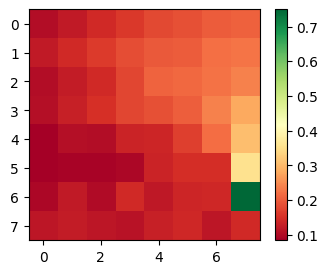

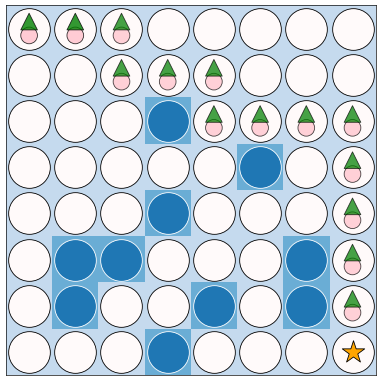

In [ ]:
# replace epsilon with 0
train_state.policy_params["params"]["epsilon"] = 0.0
transitions = rollout(env_params, train_state.policy_params, rng_rollout, n_steps=100)

plotting.plot_qvals(env, env_params, policy, train_state.policy_params)
plotting.render(transitions.env_state, env_params)
print(f"{int(100*transitions.reward.sum()/transitions.done.sum())}%")